# Title:    Next Word Prediction-Language Model

## Business Understanding:-

### Introduction:

Language modeling involves predicting the next word in a sequence given the sequence of words already present. A language model is a key element in many natural language processing models such resolving customers inquiries through chat or answering the questions through emails.

In customer Service business especially in messaging or Chats or email supports, customer representative often struggle to response fast if they have limited knowledge of business area wherein the inquiry is about and need to respond fast for better service and improved customer satisfaction

### Business Problem:

Business Stakeholder wanted to build model that would learn from previously provided chat or email resolution history and suggest the next word when representative start providing resolution to the customers inquiry.

•	Build the model that would predict the next word based on previous context.


#### Techniques:

The model would be built using Recurrent neural networks (RNN) and TensorFlow and Keras.


### Data Definitions:

Columns:

* Dataset ID: Dataset that the request originated from.
* Group ID: The group of 4 annotators that the selections originated from.
* Request ID: Unique ID of a request to allow joining between different files.
* Threshold: The threshold (i) to merge selections by.
* MergedSelections: If at least i annotators marked a character as unnecessary then it will be contained within the selected portion denoted by [ and ].
* Unselected: All text from MergedSelections not contained by [ and ].
* Selected: All text from MergedSelections contained by [ and ].
* Greeting: If a greeting of some kind (Hi, How are you) is present in Selected
* Backstory: If self-exposure language is present in Selected. The user is telling the audience about themselves, their situation, what led them to contact the agent or ask their question.
* Justification: If justification language is present in Selected. The user is giving facts to build credibility that their request or statement is true. Also can be why they need resolution or a consequence if something is not resolved.
* Rant: If ranting is present in Selected. Excessive complaining or negative narrative.
* Gratitude: If some expression of gratitude to the audience for past or future help is present in Selected.
* Other: If some or all of the highlighted section does not contain any relational language in Selected. Could be additional facts the user gave but annotators determined was unnecessary to determine their intention, or a general question such as Can you help?.
* Express Emotion: If any emotional language not covered by Rant is present in Selected



## Data Understanding:

In [2]:
# import required libraries

import numpy as np
import pandas as pd
import seaborn as sns
import heapq
import re
import nltk
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize,RegexpTokenizer
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Activation
from keras.layers import LSTM
import pickle
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
import keras
from keras import layers
from keras.models import Sequential
import random
import sys

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [6]:
# read the dataset and shoaw shape and head

# taking small dataset so it would not take time for training

corpus = pd.read_csv('sample_data/tagged_selections_by_sentence.csv')

corpus.shape
corpus.head(2)

(6759, 14)

,Dataset,Partition,SentenceID,Threshold,MergedSelections,Unselected,Selected,Greeting,Backstory,Justification,Rant,Gratitude,Other,Express Emotion
0,1,1,2227,2,[Just to set the scene... I have a fairly tall...,"if we check in online, will this mean we auto...",Just to set the scene... I have a fairly tall ...,0,1,0,0,0,1,0
1,1,1,2182,2,I am flying from Luton to Dalaman (Turkey) nex...,I am flying from Luton to Dalaman (Turkey) nex...,"We already have allocated seats, so as far as ...",0,1,0,0,0,1,0


In [7]:
# information of data

corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6759 entries, 0 to 6758
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Dataset           6759 non-null   int64 
 1   Partition         6759 non-null   int64 
 2   SentenceID        6759 non-null   int64 
 3   Threshold         6759 non-null   int64 
 4   MergedSelections  6759 non-null   object
 5   Unselected        6725 non-null   object
 6   Selected          3790 non-null   object
 7   Greeting          6759 non-null   int64 
 8   Backstory         6759 non-null   int64 
 9   Justification     6759 non-null   int64 
 10  Rant              6759 non-null   int64 
 11  Gratitude         6759 non-null   int64 
 12  Other             6759 non-null   int64 
 13  Express Emotion   6759 non-null   int64 
dtypes: int64(11), object(3)
memory usage: 739.4+ KB


### Exploratory Data Analysis:

In [8]:
# create new column

def joint_texts(str1, str2):
    
    if str1 is np.nan:
        
        str1 = ''
        
        return str2

    elif str2 is np.nan:
        
        str2 = ''
        
        return str1
        
    return str1 + ' '+ str2


#  clean text 

def clean_text(x):
    
    x = ' '.join([w.strip() for w in x.split()])
    
    return re.sub(r'[^\w]',' ',x)


corpus['text_resp'] = corpus.apply(lambda x: joint_texts(x.Unselected,x.Selected),axis=1)

corpus['text_resp'] = corpus['text_resp'].apply(lambda x: clean_text(x))

In [9]:
# create new column words list from text_resp & Count

tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')

corpus['words_list'] =  corpus['text_resp'].apply(lambda x: tokenizer.tokenize(x))
corpus['unq_words_list'] = corpus['words_list'].apply(lambda x: np.unique(x))
corpus['unq_words_list_cnt'] = corpus['unq_words_list'].apply(lambda x: len(x))

In [10]:
# show new columns 

corpus.head(2)

,Dataset,Partition,SentenceID,Threshold,MergedSelections,Unselected,Selected,Greeting,Backstory,Justification,Rant,Gratitude,Other,Express Emotion,text_resp,words_list,unq_words_list,unq_words_list_cnt
0,1,1,2227,2,[Just to set the scene... I have a fairly tall...,"if we check in online, will this mean we auto...",Just to set the scene... I have a fairly tall ...,0,1,0,0,0,1,0,if we check in online will this mean we autom...,"[if, we, check, in, online, will, this, mean, ...","[Bangkok, Emirates, I, Ideally, In, Just, My, ...",107
1,1,1,2182,2,I am flying from Luton to Dalaman (Turkey) nex...,I am flying from Luton to Dalaman (Turkey) nex...,"We already have allocated seats, so as far as ...",0,1,0,0,0,1,0,I am flying from Luton to Dalaman Turkey nex...,"[I, am, flying, from, Luton, to, Dalaman, Turk...","[1, 12, 2, Dalaman, I, Last, Luton, Monarch, N...",106


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


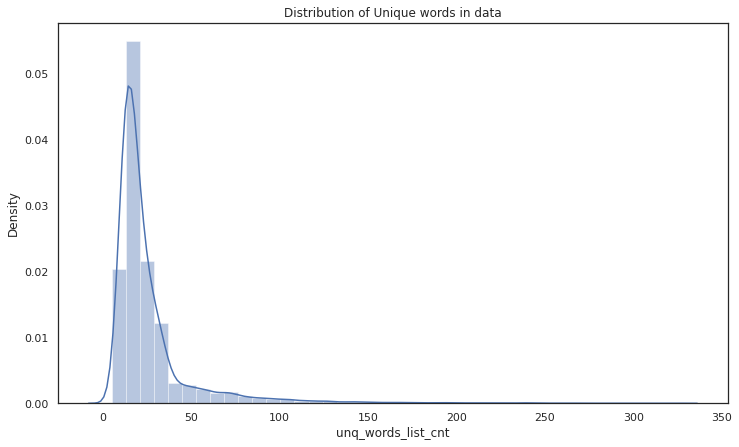

In [11]:
# distribution of unique wrods

plt.figure(figsize=(12,7))

sns.set(style='white')

sns.distplot(a=corpus['unq_words_list_cnt'],bins=40)
plt.title('Distribution of Unique words in data');

<Figure size 864x504 with 0 Axes>

Text(0.5, 1.0, 'Distribution of Greeting')

<Figure size 864x504 with 0 Axes>

Text(0.5, 1.0, 'Distribution of Gratitude')

<Figure size 864x504 with 0 Axes>

Text(0.5, 1.0, 'Distribution of Rant')

<Figure size 864x504 with 0 Axes>

Text(0.5, 1.0, 'Distribution of Backstory')

<Figure size 864x504 with 0 Axes>

Text(0.5, 1.0, 'Distribution of Justification')

<Figure size 864x504 with 0 Axes>

Text(0.5, 1.0, 'Distribution of Express Emotion')

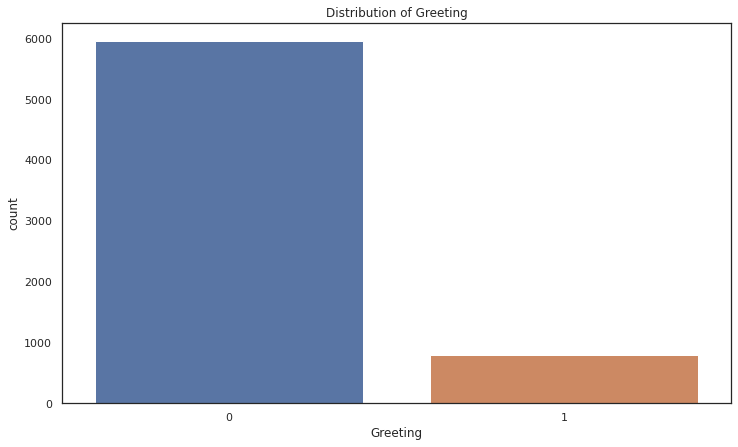

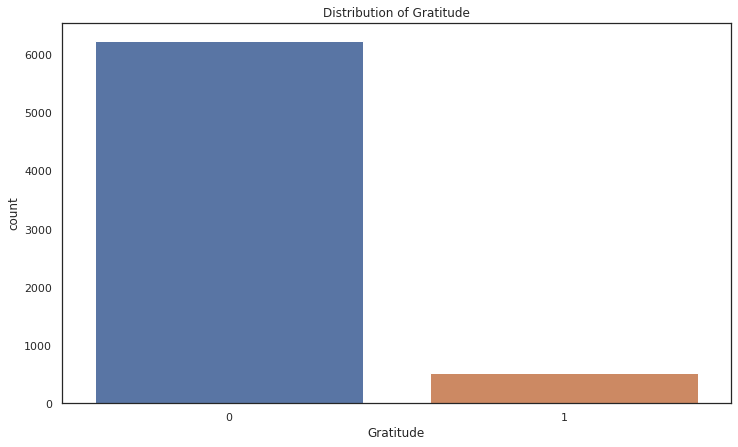

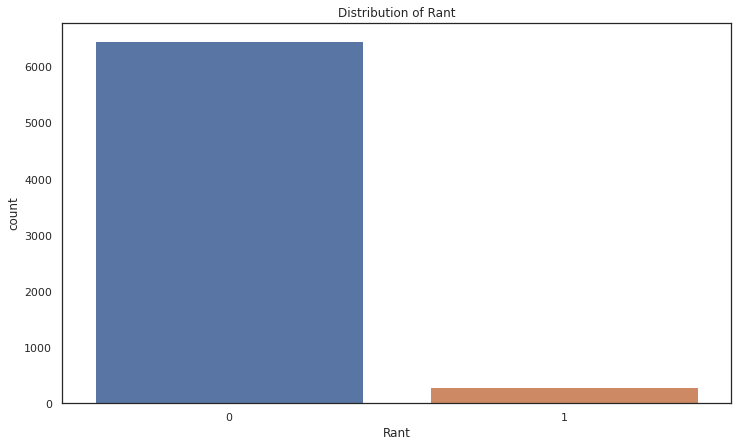

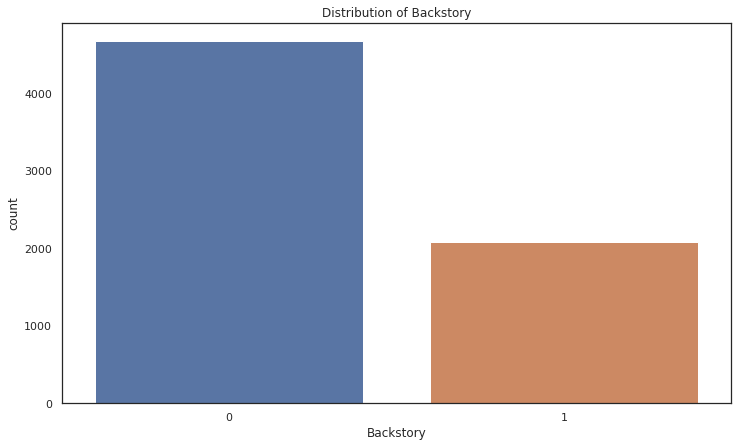

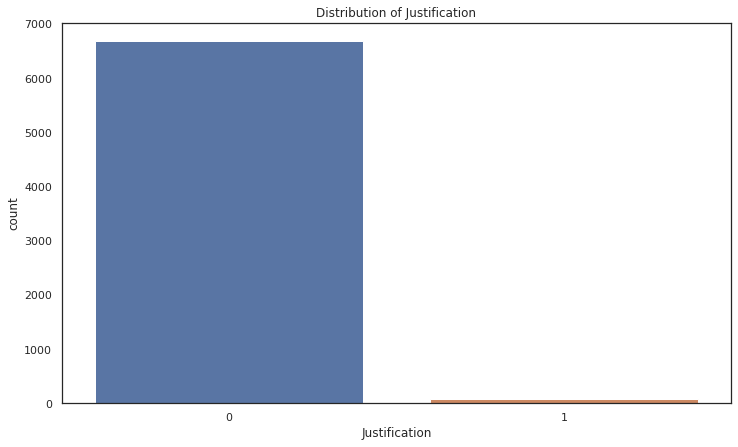

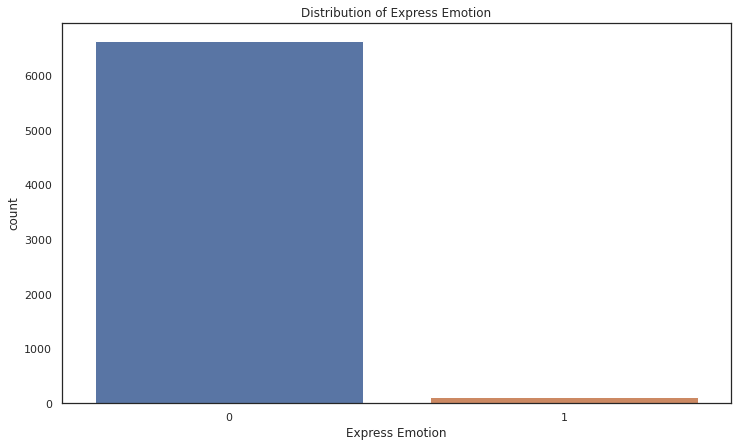

In [12]:
#  display distribution of boolean columns

bool_cols  = ['Greeting','Gratitude','Rant','Backstory','Justification','Express Emotion']

for col in bool_cols:
    
    plt.figure(figsize=(12,7))
    sns.set(style='white')
    
    sns.countplot(data=corpus, x=col)
    plt.title(f'Distribution of {col}');

In [13]:
# feature engineering

text_data = ' '.join(corpus['text_resp'].to_list())

# creating sentences form text data by specific len

maxlen = 10
step =3
sentences = []
next_chars =[]

for i in range(0, len(text_data) - maxlen, step):
    sentences.append(text_data[i:i+maxlen])
    next_chars.append(text_data[i+maxlen])
    
print('Number of Sequences: ', len(sentences))

Number of Sequences:  379612


In [14]:
# map unique chars to its index

chars = sorted(list(set(text_data)))
print('Unique characters:', len(chars))
char_indices = dict((char, chars.index(char)) for char in chars)

Unique characters: 67


In [15]:
# vectorize the text data

x = np.zeros((len(sentences), maxlen, len(chars)), dtype=bool)
y = np.zeros((len(sentences), len(chars)), dtype=bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

#### model building

In [16]:
# using single dense layer & show summary

model = Sequential()
model.add(layers.LSTM(128,input_shape = (maxlen,len(chars))))
model.add(layers.Dense(len(chars),activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               100352    
                                                                 
 dense (Dense)               (None, 67)                8643      
                                                                 
Total params: 108,995
Trainable params: 108,995
Non-trainable params: 0
_________________________________________________________________


In [17]:
#### model compilation config

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(loss = 'categorical_crossentropy',optimizer=optimizer,metrics=['acc'])

In [18]:
#  function sample the text char based on prediction

def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [23]:
#  train the model for 20 epochs

history = model.fit(x, y, validation_split=0.05, batch_size=128, epochs=20, shuffle=True).history

Epoch 1/20
2818/2818 [==============================] - 15s 5ms/step - loss: 1.2914 - acc: 0.6278 - val_loss: 1.2878 - val_acc: 0.6256
Epoch 2/20
2818/2818 [==============================] - 14s 5ms/step - loss: 1.2892 - acc: 0.6290 - val_loss: 1.3044 - val_acc: 0.6252
Epoch 3/20
2818/2818 [==============================] - 16s 6ms/step - loss: 1.2883 - acc: 0.6290 - val_loss: 1.3221 - val_acc: 0.6226
Epoch 4/20
2818/2818 [==============================] - 15s 5ms/step - loss: 1.2854 - acc: 0.6302 - val_loss: 1.3313 - val_acc: 0.6197
Epoch 5/20
2818/2818 [==============================] - 18s 6ms/step - loss: 1.2840 - acc: 0.6304 - val_loss: 1.3386 - val_acc: 0.6173
Epoch 6/20
2818/2818 [==============================] - 14s 5ms/step - loss: 1.2829 - acc: 0.6305 - val_loss: 1.3371 - val_acc: 0.6188
Epoch 7/20
2818/2818 [==============================] - 14s 5ms/step - loss: 1.2816 - acc: 0.6314 - val_loss: 1.3425 - val_acc: 0.6175
Epoch 8/20
2818/2818 [==============================] -

In [24]:
#  save the model

model.save('next_word_model.h5')
pickle.dump(history, open("history.p", "wb"))
model = load_model('next_word_model.h5')
history = pickle.load(open("history.p", "rb"))

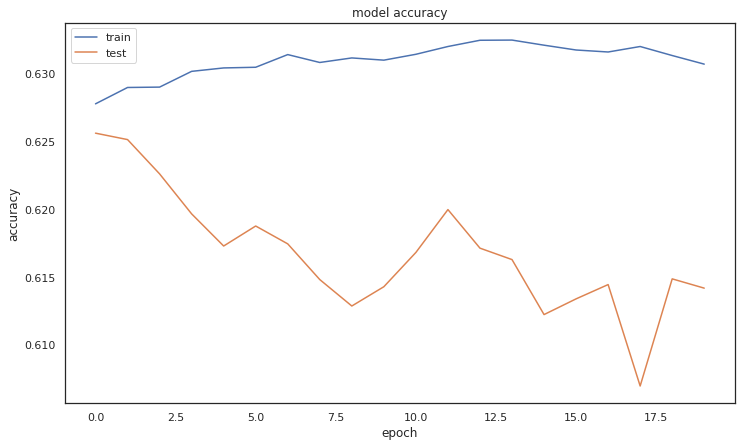

In [28]:
#  evaluating model 

plt.figure(figsize=(12,7))
sns.set(style='white')
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

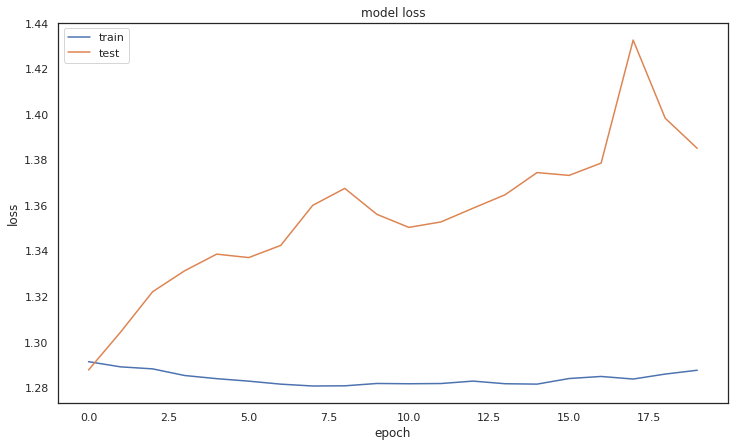

In [29]:
plt.figure(figsize=(12,7))
sns.set(style='white')
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

In [30]:
#  text generation loop & train the model

def generate_text(sample_text, temperatures):
    
    # start_index = random.randint(0, len(texttext_data) - maxlen - 1)
    # generated_text = text_data[start_index: start_index + maxlen]
    generated_text = sample_text.lower()
    print('--- Generating with seed: "' + generated_text + '"')
 
    for temperature in temperatures:
        print('\n------ temperature:', temperature)
        sys.stdout.write(generated_text)
        for i in range(400):
            sampled = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1.
            preds = model.predict(sampled, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = chars[next_index]
            generated_text += next_char
            generated_text = generated_text[1:]
            sys.stdout.write(next_char)

In [34]:
# geenrate texts
sample_text = 'I have bee'
# Sample text since temperature 0.2 generated more relevant text so used for generating smple texts

temperatures = [0.2]

for i in range(1,21):
    
    print(f'\n\n-----Sample Text#{i}---------:\n')
    generate_text(sample_text,temperatures)



-----Sample Text#1---------:

--- Generating with seed: "i have bee"

------ temperature: 0.2
i have been to change my connection  I have a travel from a train and the flight  I have a flight  I have a flight to the change the change the flight with the ticket from the airport  I have been told the ticket  I have a check in                                                                                                                                                                                   

-----Sample Text#2---------:

--- Generating with seed: "i have bee"

------ temperature: 0.2
i have been told the ticket  I do not have a flight  I have a flight to and the change the flight  I have a flight to recomment  I have a train the seats  I have the flight  I have a flight  I want to get the change the flight                                                                                                                                                                            

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


 account  I have the flight on a flight from Cancun  I have the miles                                                                                                                                                                                                                                                                         

-----Sample Text#12---------:

--- Generating with seed: "i have bee"

------ temperature: 0.2
i have been an airline  I have the fare                                                                                                                                                                                                                                                                                                                                                                                   

-----Sample Text#13---------:

--- Generating with seed: "i have bee"

------ temperature: 0.2
i have been told that the connection  I have a flight  I m try

# END